In [22]:
from qpms import Particle, CTMatrix, BaseSpec, FinitePointGroup, ScatteringSystem, TMatrixInterpolator, dbgmsg_enable, dbgmsg_disable, dbgmsg_active, BesselType,  eV, ℏ , TMatrixGenerator, c
from qpms.symmetries import point_group_info
from qpms.cymaterials import EpsMuGenerator, EpsMu, LorentzDrudeModel, lorentz_drude
from qpms.cybspec import BaseSpec
import numpy as np


In [17]:
edge_len = 3.0e-6
edge_npart = 7
ω = 2.1*eV/ℏ # Currently, we need to set the frequency first and then repeat the whole process with another if needed
refractive_index = 1.52 # for background medium

h = 60e-9 # Edge particle height
r = 70e-9 # Edge particle radius
R = 150e-9 # Central particle radius

medium = EpsMu(refractive_index**2) # non-lossy background medium with constant refr. index
metal = lorentz_drude['Au']

In [18]:
# T-matrix generators, currently used only once
tmgen_edge = TMatrixGenerator.cylinder(medium, metal, r, h, lMax_extend=6)
tmgen_central = TMatrixGenerator.sphere(medium, metal, R)

In [19]:
# global symmetry group of the system
sym = FinitePointGroup(point_group_info['D3h'])
# cutoff for the smaller particles
bspec_edge = BaseSpec(lMax=3)
# let the central particle be larger, hence we need larger lMax
bspec_central = BaseSpec(lMax=6)

# T-matrices
T_edge = tmgen_edge(bspec_edge, ω)
T_central = tmgen_central(bspec_central, ω)

# Generate the particle list:
particles = [Particle((0, 0), T_central)]
y = edge_len / (2*3**.5)
for x in np.linspace(-edge_len/2,edge_len/2,edge_npart):
    particles.append(Particle((x,y), T_edge))
    particles.append(Particle((x,-y), T_edge))
    
# Ready to go
ss = ScatteringSystem(particles, sym)

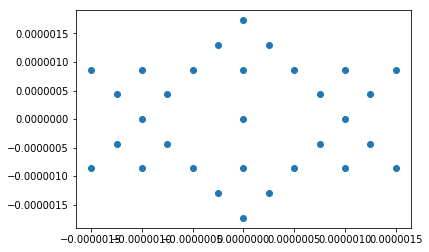

In [21]:
# Check the generated positions
%matplotlib inline
from matplotlib import pyplot as plt
pos = ss.positions[:,:2]
plt.plot(pos[:,0], pos[:,1], 'o')

In [27]:
# Let's solve some scattering problems:
wavenumber = medium.k(ω).real # Currently, ScatteringSystem does not "remember" frequency nor wavenumber

#LU = [ss.scatter_solver(wavenumber, iri) for iri in range(ss.nirreps)]
LU_full = ss.scatter_solver(wavenumber)

# Try with y-polarised waves with incident direction 
# rotated along the y axis in the interval [-π/4, π/4]
sinalpha_list = np.linspace(-1,1,51)
σ_ext_list = list()
σ_scat_list = list()

for sinalpha in sinalpha_list:
    ã = ss.planewave_full(k_cart=(sinalpha, 0, 1), E_cart=(0, 1, 0))
    f = LU_full(ã)
    translation_matrix = ss.translation_matrix_full(wavenumber, BesselType.REGULAR)
    σ_ext = -np.vdot(ã, f).real/wavenumber**2
    σ_scat = -np.vdot(f,np.dot(translation_matrix, f))
    σ_ext_list.append(σ_ext)
    σ_scat_list.append(σ_scat)
    


In [28]:
σ_ext_list

[-2.1948841804917656e-11,
 -2.1955402246511587e-11,
 -2.1959957672641152e-11,
 -2.1962247140203016e-11,
 -2.1962006975505304e-11,
 -2.1958978410586664e-11,
 -2.1952917323618097e-11,
 -2.1943606231046096e-11,
 -2.193086855348143e-11,
 -2.1914584990386037e-11,
 -2.189471158348815e-11,
 -2.187129872610645e-11,
 -2.1844509997699325e-11,
 -2.181463929922472e-11,
 -2.1782124385001952e-11,
 -2.174755460169902e-11,
 -2.1711670542802044e-11,
 -2.1675353500935292e-11,
 -2.1639603130148287e-11,
 -2.160550265521825e-11,
 -2.1574172257071482e-11,
 -2.1546712806501935e-11,
 -2.1524143704954406e-11,
 -2.1507339944767704e-11,
 -2.149697432694409e-11,
 -2.1493470829386036e-11,
 -2.149697432694409e-11,
 -2.1507339944767704e-11,
 -2.1524143704954416e-11,
 -2.1546712806501935e-11,
 -2.1574172257071486e-11,
 -2.1605502655218247e-11,
 -2.1639603130148293e-11,
 -2.167535350093529e-11,
 -2.171167054280205e-11,
 -2.1747554601699016e-11,
 -2.1782124385001955e-11,
 -2.1814639299224725e-11,
 -2.184450999769933e-1